In [26]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import re
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, TensorBoard

#plt.style.use('seaborn')
plt.style.use('ggplot')

Reads a subcategory of Amazon reviews into a pandas dataframe, and saves 2000 rows as a .pkl file.

Restarting Kernal while only running the following cell allows EDA without excessive memory use

In [5]:
#Set 'small_sample_pickled' to False to create'data/small_df.pkl'
small_sample_pickled = True

if not small_sample_pickled:
    df = pd.read_csv('data/gaming_reviews.tsv', sep='\t', error_bad_lines=False)
    df['text'] = df.review_headline + df.review_body
    
    #Drops any text that has a NaN
    df = df[~df.text.isnull()].reset_index(drop=True)
    df = df[['text', 'star_rating']]
    
    df = df[0:4000]
    df.to_pickle('data/small_df.pkl')

In [6]:
df = pd.read_pickle("data/small_df.pkl")
df.shape

(4000, 2)

The review_headline and review_body columns will both be useful for prediction.
Review date might be useful as well, such as day of the week reviewed. 

0.5 2300 1: 0.10
0.5 2100 2: 0.04
0.5 1900 3: 0.06
0.5 1700 4: 0.13
0.5 1500 5: 0.66


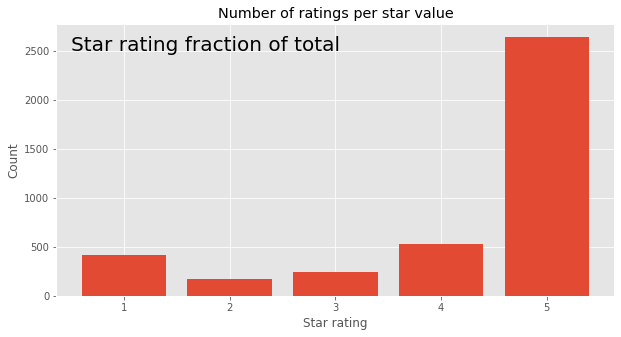

In [9]:
#Creates a list with the number of ratings per star
rating_count_list = []
possible_ratings = [1, 2, 3, 4, 5]

for rating in possible_ratings:
    rating_count_list.append(df[df['star_rating'] == rating].shape[0])
    
#Creates array that stores fraction of the total star values
rating_proportion = np.array(rating_count_list)/sum(rating_count_list)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(possible_ratings, rating_count_list)

ax.set_xlabel('Star rating')
ax.set_ylabel('Count')
ax.set_title('Number of ratings per star value')
ax.text(0.5, 2500, 'Star rating fraction of total', fontsize=20)

print(0.5, 2300, '1: {:0.2f}'.format(rating_proportion[0]))
print(0.5, 2100, '2: {:0.2f}'.format(rating_proportion[1]))
print(0.5, 1900, '3: {:0.2f}'.format(rating_proportion[2]))
print(0.5, 1700, '4: {:0.2f}'.format(rating_proportion[3]))
print(0.5, 1500, '5: {:0.2f}'.format(rating_proportion[4]))

In [10]:
strip_chars = ".?,!;:\"'()" 
rgx = re.compile('[%s]' % strip_chars)

def process_str(row):

    body_list = []
    try:
        for word in row.lower().split(): 
            body_list.append(rgx.sub('', word))
        return body_list
    except Exception as e:
        print(e)
        return ['']

In [11]:
#Count vectorizes text into a sparse vector
cv = CountVectorizer(strip_accents='ascii')
sparse_vec = cv.fit_transform(df.text)


In [12]:
def autoencoder_model(X_train):
    '''
    defines autoencoder model
    input: X_train (2D np array)
    output: autoencoder (compiled autoencoder model)
    '''
    # this is our input placeholder
    input_img = Input(shape=(X_train[0].shape[1],))

    # first encoding layer
    encoded1 = Dense(units = 256, activation = 'relu')(input_img)

    # second encoding layer
    # note that each layer is multiplied by the layer before
    encoded2 = Dense(units = 64, activation='relu')(encoded1)

    # first decoding layer
    decoded1 = Dense(units = 256, activation='relu')(encoded2)

    # second decoding layer - this produces the output
    decoded2 = Dense(units = X_train[0].shape[1], activation='sigmoid')(decoded1)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded2)

    # compile model
    autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

    return autoencoder

In [21]:
#Train test split for small sample size
test_stop_index = int(sparse_vec.shape[0] * 0.1)
X_test = sparse_vec[0:test_stop_index]
X_train = sparse_vec[test_stop_index:]

In [22]:
def batch_generator(X, batch_size):
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(X)[0])
    np.random.shuffle(shuffle_index)
    
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch]
        X_batch = X_batch.toarray()
        counter += 1
        yield X_batch, X_batch
        
        
        if (counter > number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

In [23]:
model = autoencoder_model(X_train)

batch_size = 1000
nb_epoch = 10
samples_per_epoch = 10

# instantiate callbacks
tensorboard = TensorBoard(log_dir='./autoencoder_logs', histogram_freq=2, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=2)

# try different number of epochs - 10 gives good performanace 
"""model.fit(X_train, X_train, epochs=10, batch_size=batch_size, verbose=1,
          validation_split=0.1, callbacks = [earlystopping, tensorboard])""" # cross val to estimate test error


model.fit_generator(generator=batch_generator(X_train, batch_size),
                    epochs=nb_epoch,
                    samples_per_epoch=samples_per_epoch)


scores = model.evaluate(X_test, X_test)
print('Test mse = {}'.format(scores[0]))

X_test_decoded = model.predict(X_test)





/home/tyler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<generator..., epochs=10, steps_per_epoch=10)`


Epoch 1/10
10/10 [==============================] - 9s 893ms/step - loss: 0.2519 - mean_squared_error: 0.2519
Epoch 2/10
10/10 [==============================] - 8s 840ms/step - loss: 0.1446 - mean_squared_error: 0.1446
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 0.0366 - mean_squared_error: 0.0366
Epoch 4/10
10/10 [==============================] - 14s 1s/step - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 5/10
10/10 [==============================] - 10s 973ms/step - loss: 0.0169 - mean_squared_error: 0.0169
Epoch 6/10
10/10 [==============================] - 8s 809ms/step - loss: 0.0195 - mean_squared_error: 0.0195
Epoch 7/10
10/10 [==============================] - 9s 864ms/step - loss: 0.0177 - mean_squared_error: 0.0177
Epoch 8/10
10/10 [==============================] - 10s 959ms/step - loss: 0.0144 - mean_squared_error: 0.0144
Epoch 9/10
10/10 [==============================] - 8s 841ms/step - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 10/10
